# NB02: PHB Pathway Distribution Across the Bacterial Tree

**Purpose**: Map PHB pathway completeness across the GTDB taxonomy to identify clades enriched or depleted for PHB capability.

**Requires**: BERDL JupyterHub (Spark session)

**Inputs**: `data/phb_species_summary.tsv` from NB01

**Outputs**:
- `data/phb_by_taxonomy.tsv` — PHB prevalence by phylum/class/order/family
- `figures/phb_prevalence_by_phylum.png` — PHB prevalence heatmap across phyla
- `figures/phb_core_vs_accessory.png` — Core vs accessory phaC across clades
- `figures/phb_pathway_completeness.png` — Pathway completeness distribution

In [1]:
spark = get_spark_session()

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_DIR = os.path.expanduser('~/BERIL-research-observatory/projects/phb_granule_ecology')
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
FIG_DIR = os.path.join(PROJECT_DIR, 'figures')

# Load NB01 results
species_phb = pd.read_csv(os.path.join(DATA_DIR, 'phb_species_summary.tsv'), sep='\t')
print(f'Loaded {len(species_phb):,} species with PHB genes')

Loaded 19,496 species with PHB genes


In [2]:
# Get full taxonomy for all species
# Parse taxonomy ranks directly from GTDB_taxonomy string in gtdb_species_clade
# Format: d__Domain;p__Phylum;c__Class;o__Order;f__Family;g__Genus;s__Species
# This avoids the broken join to gtdb_taxonomy_r214v1 (representative_genome_id != gtdb_taxonomy_id)
taxonomy = spark.sql("""
    SELECT sc.gtdb_species_clade_id,
           sc.GTDB_taxonomy,
           REGEXP_EXTRACT(sc.GTDB_taxonomy, 'p__([^;]+)', 1) AS gtdb_phylum,
           REGEXP_EXTRACT(sc.GTDB_taxonomy, 'c__([^;]+)', 1) AS gtdb_class,
           REGEXP_EXTRACT(sc.GTDB_taxonomy, 'o__([^;]+)', 1) AS gtdb_order,
           REGEXP_EXTRACT(sc.GTDB_taxonomy, 'f__([^;]+)', 1) AS gtdb_family,
           REGEXP_EXTRACT(sc.GTDB_taxonomy, 'g__([^;]+)', 1) AS gtdb_genus,
           p.no_genomes, p.no_core, p.no_aux_genome, p.no_gene_clusters
    FROM kbase_ke_pangenome.gtdb_species_clade sc
    JOIN kbase_ke_pangenome.pangenome p
        ON sc.gtdb_species_clade_id = p.gtdb_species_clade_id
""").toPandas()

print(f'Total species with taxonomy: {len(taxonomy):,}')
print(f'Phyla: {taxonomy["gtdb_phylum"].nunique()}')
print(f'Sample taxonomy:')
taxonomy[['gtdb_species_clade_id', 'gtdb_phylum', 'gtdb_class', 'gtdb_order']].head(3)

Total species with taxonomy: 27,690
Phyla: 142
Sample taxonomy:


,gtdb_species_clade_id,gtdb_phylum,gtdb_class,gtdb_order
0,s__Klebsiella_pneumoniae--RS_GCF_000742135.1,Pseudomonadota,Gammaproteobacteria,Enterobacterales
1,s__Staphylococcus_aureus--RS_GCF_001027105.1,Bacillota,Bacilli,Staphylococcales
2,s__Salmonella_enterica--RS_GCF_000006945.2,Pseudomonadota,Gammaproteobacteria,Enterobacterales


In [3]:
# Merge PHB status with taxonomy
# Species not in species_phb are PHB-absent
tax_phb = taxonomy.merge(species_phb[['gtdb_species_clade_id', 'phb_status', 'phb_genes_str', 
                                       'phaC_is_core', 'phaC_is_aux']],
                          on='gtdb_species_clade_id', how='left')
tax_phb['phb_status'] = tax_phb['phb_status'].fillna('absent')
# Cast to int to avoid numpy boolean arithmetic issues in downstream aggregations
tax_phb['has_phaC'] = tax_phb['phb_status'].isin(['complete', 'synthase_only']).astype(int)
tax_phb['has_complete_pathway'] = (tax_phb['phb_status'] == 'complete').astype(int)

print('PHB pathway status across all species:')
print(tax_phb['phb_status'].value_counts())
print(f'\nOverall phaC prevalence: {tax_phb["has_phaC"].mean()*100:.1f}%')
print(f'Overall complete pathway: {tax_phb["has_complete_pathway"].mean()*100:.1f}%')

PHB pathway status across all species:
phb_status
precursors_only    12869
absent              8199
complete            6005
accessory_only       555
synthase_only         62
Name: count, dtype: int64

Overall phaC prevalence: 21.9%
Overall complete pathway: 21.7%


In [4]:
# PHB prevalence by phylum
phylum_stats = tax_phb.groupby('gtdb_phylum').agg(
    n_species=('gtdb_species_clade_id', 'count'),
    n_phaC=('has_phaC', 'sum'),
    pct_phaC=('has_phaC', lambda x: x.mean() * 100),
    n_complete=('has_complete_pathway', 'sum'),
    pct_complete=('has_complete_pathway', lambda x: x.mean() * 100),
).round(1).sort_values('n_species', ascending=False)

print('PHB prevalence by phylum (>50 species):')
phylum_stats[phylum_stats['n_species'] >= 50]

PHB prevalence by phylum (>50 species):


,n_species,n_phaC,pct_phaC,n_complete,pct_complete
gtdb_phylum,,,,,
Pseudomonadota,7456,4544,60.9,4539,60.9
Bacillota_A,3917,71,1.8,56,1.4
Bacteroidota,3629,78,2.1,75,2.1
Actinomycetota,3172,587,18.5,578,18.2
Bacillota,2146,187,8.7,175,8.2
Patescibacteria,981,4,0.4,2,0.2
Verrucomicrobiota,553,6,1.1,3,0.5
Cyanobacteriota,469,43,9.2,42,9.0
Chloroflexota,457,56,12.3,56,12.3


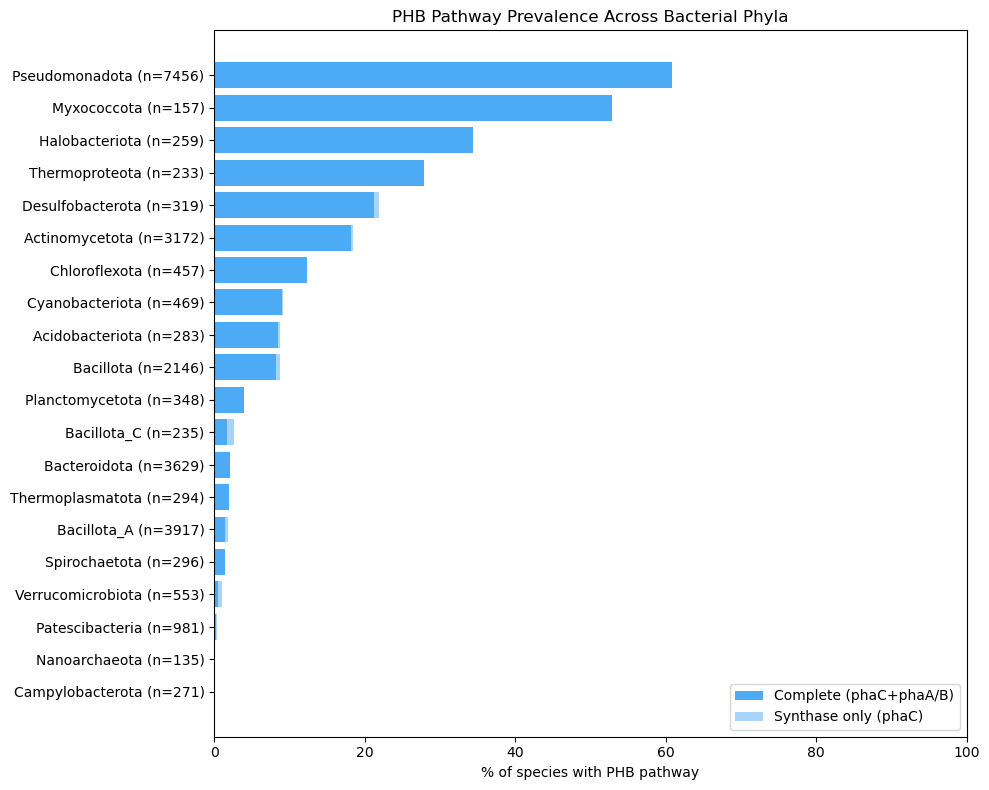

Saved phb_prevalence_by_phylum.png


In [5]:
# Figure 1: PHB prevalence by phylum (top 20 phyla by species count)
top_phyla = phylum_stats.head(20).sort_values('pct_phaC', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(range(len(top_phyla)), top_phyla['pct_complete'], 
               label='Complete (phaC+phaA/B)', color='#2196F3', alpha=0.8)
ax.barh(range(len(top_phyla)), top_phyla['pct_phaC'] - top_phyla['pct_complete'],
        left=top_phyla['pct_complete'],
        label='Synthase only (phaC)', color='#90CAF9', alpha=0.8)

ax.set_yticks(range(len(top_phyla)))
ax.set_yticklabels([f"{p} (n={int(n)})" for p, n in 
                     zip(top_phyla.index, top_phyla['n_species'])])
ax.set_xlabel('% of species with PHB pathway')
ax.set_title('PHB Pathway Prevalence Across Bacterial Phyla')
ax.legend(loc='lower right')
ax.set_xlim(0, 100)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'phb_prevalence_by_phylum.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved phb_prevalence_by_phylum.png')

In [6]:
# PHB prevalence by order (finer resolution)
order_stats = tax_phb.groupby(['gtdb_phylum', 'gtdb_class', 'gtdb_order']).agg(
    n_species=('gtdb_species_clade_id', 'count'),
    n_phaC=('has_phaC', 'sum'),
    pct_phaC=('has_phaC', lambda x: x.mean() * 100),
    n_complete=('has_complete_pathway', 'sum'),
    pct_complete=('has_complete_pathway', lambda x: x.mean() * 100),
).round(1).sort_values('n_species', ascending=False)

print(f'Orders with >20 species and >50% phaC prevalence:')
enriched = order_stats[(order_stats['n_species'] >= 20) & (order_stats['pct_phaC'] >= 50)]
enriched.sort_values('pct_phaC', ascending=False)

Orders with >20 species and >50% phaC prevalence:


n_species  n_phaC  \
gtdb_phylum      gtdb_class          gtdb_order                              
Pseudomonadota   Alphaproteobacteria Azospirillales             25      25   
                                     Rhodospirillales           20      20   
                                     Caulobacterales           142     141   
                                     Sphingomonadales          292     280   
                 Gammaproteobacteria Legionellales              64      61   
                 Alphaproteobacteria Rhodobacterales           415     392   
                                     Micavibrionales            35      33   
                 Gammaproteobacteria Xanthomonadales           289     266   
                 Alphaproteobacteria Rhizobiales               813     718   
Eremiobacterota  Eremiobacteria      Baltobacterales            20      16   
Thermoproteota   Nitrososphaeria     Nitrososphaerales          84      65   
Pseudomonadota   Gammaproteobacteria Burkholderiales          1379    1059   
Chloroflexota    Chloroflexia        Chloroflexales             21      15   
Pseudomonadota   Alphaproteobacteria Rhodospirillales_A         47      33   
                 Gammaproteobacteria Chromatiales               58      40   
Myxococcota      Polyangia           Polyangiales               34      23   
Pseudomonadota   Gammaproteobacteria Pseudomonadales          1188     801   
                                     Arenicellales              32      20   
Halobacteriota   Halobacteria        Halobacteriales           120      74   
Actinomycetota   Actinomycetia       Mycobacteriales           689     408   
Pseudomonadota   Gammaproteobacteria Steroidobacterales         44      26   
Myxococcota      Myxococcia          Myxococcales               41      24   
Desulfobacterota Syntrophia          Syntrophales               45      25   

                                                         pct_phaC  n_complete  \
gtdb_phylum      gtdb_class          gtdb_order                                 
Pseudomonadota   Alphaproteobacteria Azospirillales         100.0          25   
                                     Rhodospirillales       100.0          20   
                                     Caulobacterales         99.3         141   
                                     Sphingomonadales        95.9         280   
                 Gammaproteobacteria Legionellales           95.3          61   
                 Alphaproteobacteria Rhodobacterales         94.5         392   
                                     Micavibrionales         94.3          33   
                 Gammaproteobacteria Xanthomonadales         92.0         266   
                 Alphaproteobacteria Rhizobiales             88.3         718   
Eremiobacterota  Eremiobacteria      Baltobacterales         80.0          16   
Thermoproteota   Nitrososphaeria     Nitrososphaerales       77.4          65   
Pseudomonadota   Gammaproteobacteria Burkholderiales         76.8        1056   
Chloroflexota    Chloroflexia        Chloroflexales          71.4          15   
Pseudomonadota   Alphaproteobacteria Rhodospirillales_A      70.2          33   
                 Gammaproteobacteria Chromatiales            69.0          40   
Myxococcota      Polyangia           Polyangiales            67.6          23   
Pseudomonadota   Gammaproteobacteria Pseudomonadales         67.4         801   
                                     Arenicellales           62.5          20   
Halobacteriota   Halobacteria        Halobacteriales         61.7          74   
Actinomycetota   Actinomycetia       Mycobacteriales         59.2         408   
Pseudomonadota   Gammaproteobacteria Steroidobacterales      59.1          26   
Myxococcota      Myxococcia          Myxococcales            58.5          24   
Desulfobacterota Syntrophia          Syntrophales            55.6          25   

                                                         pct_complete  
gtdb_phy

In [7]:
# Orders depleted for PHB
print(f'Orders with >20 species and <10% phaC prevalence:')
depleted = order_stats[(order_stats['n_species'] >= 20) & (order_stats['pct_phaC'] < 10)]
depleted.sort_values('pct_phaC', ascending=True)

Orders with >20 species and <10% phaC prevalence:


,,,n_species,n_phaC,pct_phaC,n_complete,pct_complete
gtdb_phylum,gtdb_class,gtdb_order,,,,,
Bacillota,Bacilli,RF39,251,0,0.0,0,0.0
Patescibacteria,Paceibacteria,UBA9983_A,208,0,0.0,0,0.0
Cyanobacteriota,Cyanobacteriia,PCC-6307,167,0,0.0,0,0.0
Campylobacterota,Campylobacteria,Campylobacterales,265,0,0.0,0,0.0
Bacillota,Bacilli,Paenibacillales,149,0,0.0,0,0.0
...,...,...,...,...,...,...,...
Deinococcota,Deinococci,Deinococcales,52,3,5.8,3,5.8
Desulfobacterota_F,Desulfuromonadia,Geobacterales,33,2,6.1,2,6.1
Bacillota_B,Desulfotomaculia,Desulfotomaculales,24,2,8.3,2,8.3


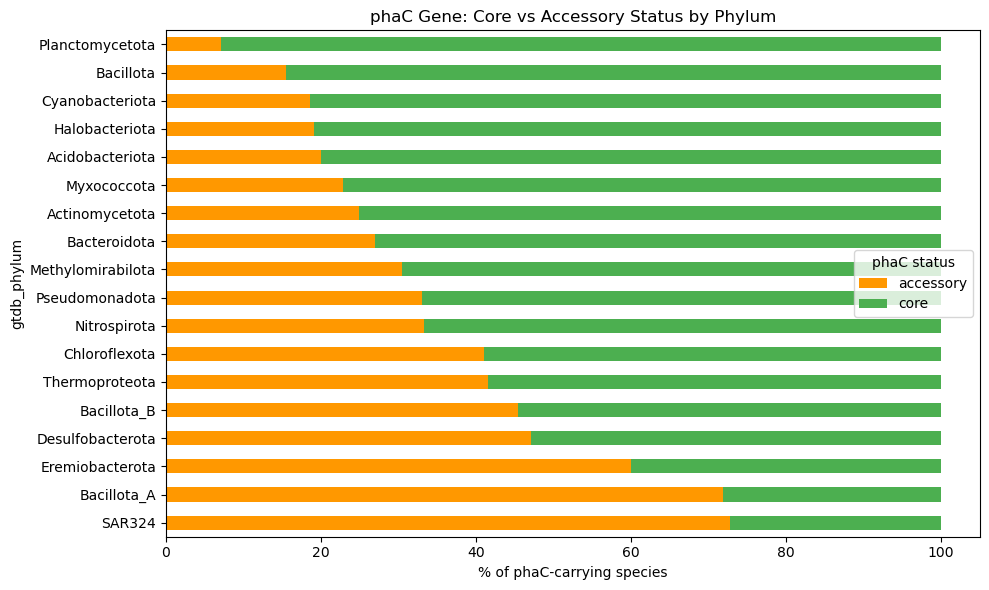

In [8]:
# Figure 2: phaC core vs accessory across phyla
phac_species = tax_phb[tax_phb['has_phaC'] == 1].copy()
phac_species['phaC_status'] = 'unknown'
phac_species.loc[phac_species['phaC_is_core'] == 1, 'phaC_status'] = 'core'
phac_species.loc[phac_species['phaC_is_aux'] == 1, 'phaC_status'] = 'accessory'

phac_by_phylum = phac_species.groupby(['gtdb_phylum', 'phaC_status']).size().unstack(fill_value=0)
phac_by_phylum = phac_by_phylum.loc[phac_by_phylum.sum(axis=1) >= 10]
phac_by_phylum_pct = phac_by_phylum.div(phac_by_phylum.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(10, 6))
phac_by_phylum_pct.sort_values('core', ascending=True).plot.barh(
    stacked=True, ax=ax, color={'core': '#4CAF50', 'accessory': '#FF9800', 'unknown': '#9E9E9E'}
)
ax.set_xlabel('% of phaC-carrying species')
ax.set_title('phaC Gene: Core vs Accessory Status by Phylum')
ax.legend(title='phaC status')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'phb_core_vs_accessory.png'), dpi=150, bbox_inches='tight')
plt.show()

/tmp/ipykernel_11910/2888123116.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([s.replace('_', '\n') for s in status_order])


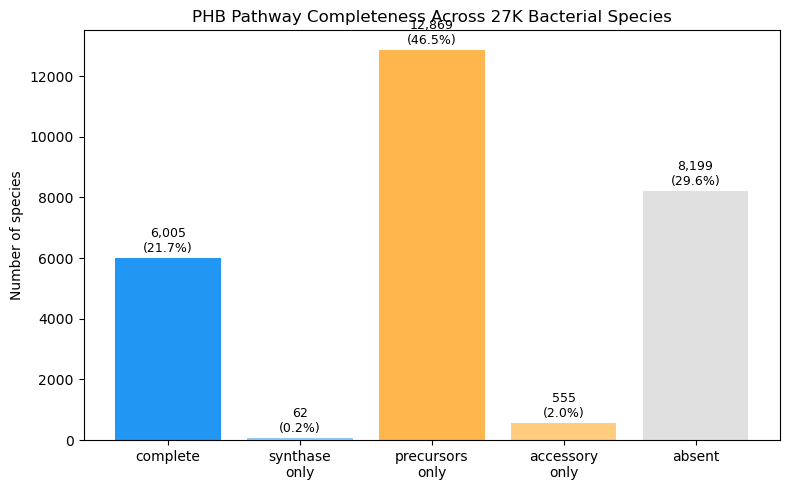

In [9]:
# Figure 3: Pathway completeness distribution
status_order = ['complete', 'synthase_only', 'precursors_only', 'accessory_only', 'absent']
status_colors = ['#2196F3', '#90CAF9', '#FFB74D', '#FFCC80', '#E0E0E0']

fig, ax = plt.subplots(figsize=(8, 5))
counts = [len(tax_phb[tax_phb['phb_status'] == s]) for s in status_order]
bars = ax.bar(status_order, counts, color=status_colors)

for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 100,
            f'{count:,}\n({count/len(tax_phb)*100:.1f}%)',
            ha='center', va='bottom', fontsize=9)

ax.set_ylabel('Number of species')
ax.set_title('PHB Pathway Completeness Across 27K Bacterial Species')
ax.set_xticklabels([s.replace('_', '\n') for s in status_order])

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'phb_pathway_completeness.png'), dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# Save taxonomy-level results
tax_phb.to_csv(os.path.join(DATA_DIR, 'phb_by_taxonomy.tsv'), sep='\t', index=False)
order_stats.to_csv(os.path.join(DATA_DIR, 'phb_by_order.tsv'), sep='\t')
print(f'Saved taxonomy data: {len(tax_phb):,} species, {len(order_stats):,} orders')

Saved taxonomy data: 27,690 species, 1,058 orders


## Summary

### Key Findings (to be filled after execution)
- PHB prevalence across all bacteria: ?%
- Most enriched phyla: ?
- Most depleted phyla: ?
- phaC core vs accessory: ?

### Next Notebook (NB03)
Correlate PHB pathway presence with environmental metadata and AlphaEarth embeddings.